In [2]:
import numpy as np
from IPython.display import Image, display

import matplotlib.pyplot as plt
%matplotlib inline


## Motivation: eigenvector alignment and dimensionality

Text(0.5, 1.0, 'Leading eigenvector and first iterate A b')

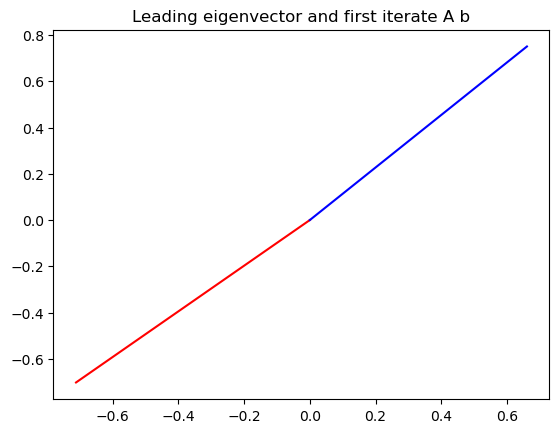

In [99]:


np.random.seed(0) # ensures same every time
A = np.random.random((10, 10))
A = A.T + A # Hermitian matrix
b = np.random.random((10,))

n = 2
A, b = A[:n, :n], b[:n]

eig_vals, eig_vecs = np.linalg.eigh(A)

eig_vec_leading = eig_vecs[np.argmax(np.abs(eig_vals))]


plt.plot([0, eig_vec_leading[0]], [0, eig_vec_leading[1]], 'r-')


y = A @ b
y /= np.linalg.norm(y)
plt.plot([0, y[0]], [0, y[1]], 'b-', label='A @ b')

plt.title('Leading eigenvector and first iterate A b')


# Krylov subspace methods

+ We've seen several iterative algorithms that involve repeatedly multiplying a matrix by a vector (QR algorithm, power method, etc)
+ Our choice of target vector $\mathbf{b}$ and our operator $A$ jointly define a the *Krylov* subspace of the pair

$$
{\displaystyle {\mathcal {K}}_{r}(A,b)=\operatorname {span} \,\{b,Ab,A^{2}b,\ldots ,A^{r-1}b\}.}
$$

It's called a subspace because it is often a subspace of the column span of $A$ that depends on $\mathbf{b}$. We can choose any value of $r$ up to a maximum $r_{max} \leq \text{rank}(A) + 1$ (the full column space)

### Properties of the Krylov subspace

+ The matrix $A$ performs a shift on the Krylov subspace:  $\displaystyle {\mathcal {K}}_{r}(A,b),A{\mathcal {K}}_{r}(A,b)\subset {\mathcal {K}}_{r+1}(A,b)$
+ If $r > r_{max}$, then the Krylov subspace is rank-deficient (there are linearly dependent matrices)
+ If $A$ is full-rank $N \times N$ matrix, then ${\mathcal {K}}_{r_{max}}(A,b)$ is also a full-rank $N \times N$ matrix

### Why use Krylov subspaces?

Suppose a linear equation has a residual vector:
$$
\mathbf{r} = A \mathbf{x} - \mathbf{b}
$$
For example, if we are performing partial linear regression, then the residual denotes our error terms

Different Krylov subspace methods boil down to choosing a vector $\mathbf{x}$, and thus subspace $\mathcal {K}_{j}(A,b)$, for which the residual satisfies certain desiderata:

1. Minimize $|| \mathbf{r} ||$. Iterative least-squares via GMRES, MINRES
2. Minimize $|| {\mathcal{K}_j} \cdot\mathbf{r} ||$ (find orthogonal residual). Conjugate gradient method

where $\mathcal{K}_j$ is shorthand for $\mathcal {K}_{j}(A,b)$. In these iterative algorithms, we seek to minimize the desired cost function at each step $i$, corresponding to a single power iteration of the matrix. 



## Arnoldi iteration

+ An eigenvalue calculation algorithm
+ Similar to QR factorization, but allows us to stop after the first $m \ll n$ terms of the factorization of the full matrix $A \in \mathbb{R}^{N \times N}$
+ The full factorization of this matrix would have the form $A= Q H Q^{-1}$
+ But if we want to just compute the first $m$ eigenvalues of a matrix, we want a lower-rank approximation of $Q$
+ The partial matrix $Q_m \in \mathbb{R}^{N \times M}$ has the property


$$
Q_{m + 1}^{-1} A Q_m =  \tilde{H}_m
$$
where $\tilde{H}_m \in \mathbb{R}^{(M+1) \times M}$ is the first $m$ and $m+1$ elements of the full Hessenberg matrix $H$.

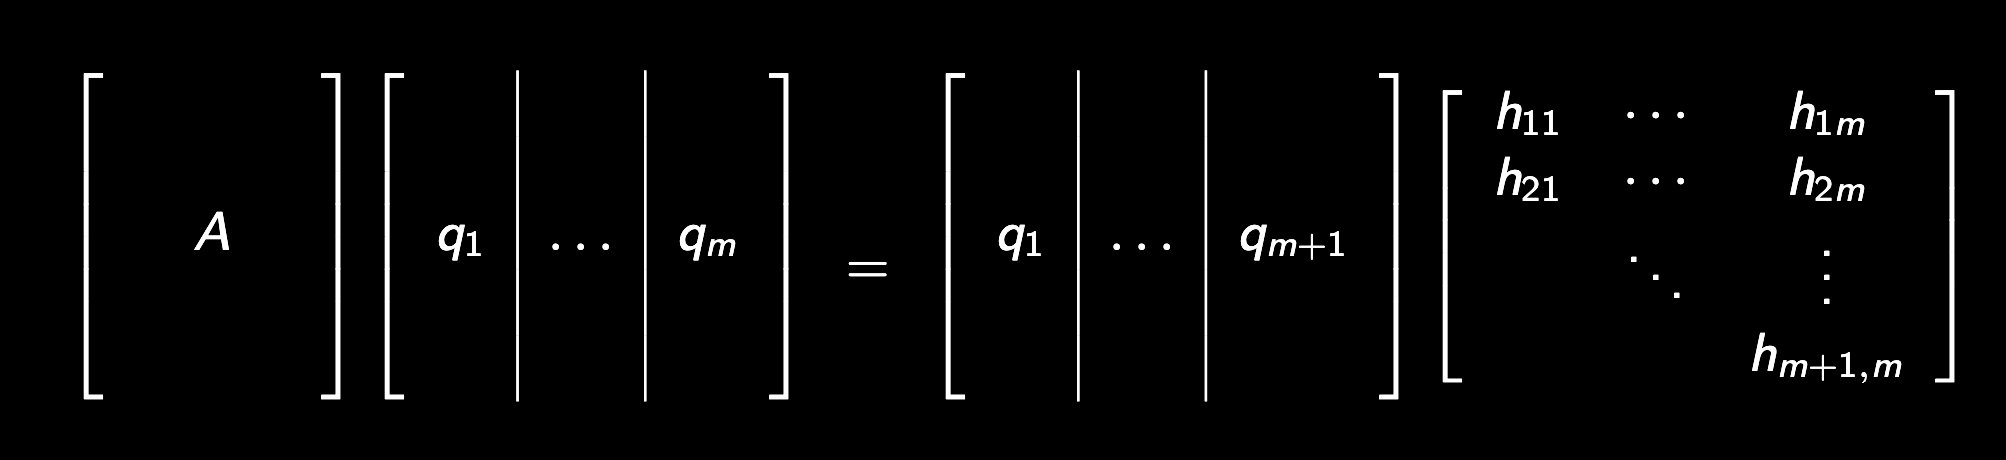

In [204]:
Image(filename='../resources/arnoldi1.png', width=750)
# Source: Chris Rycroft's lecture notes

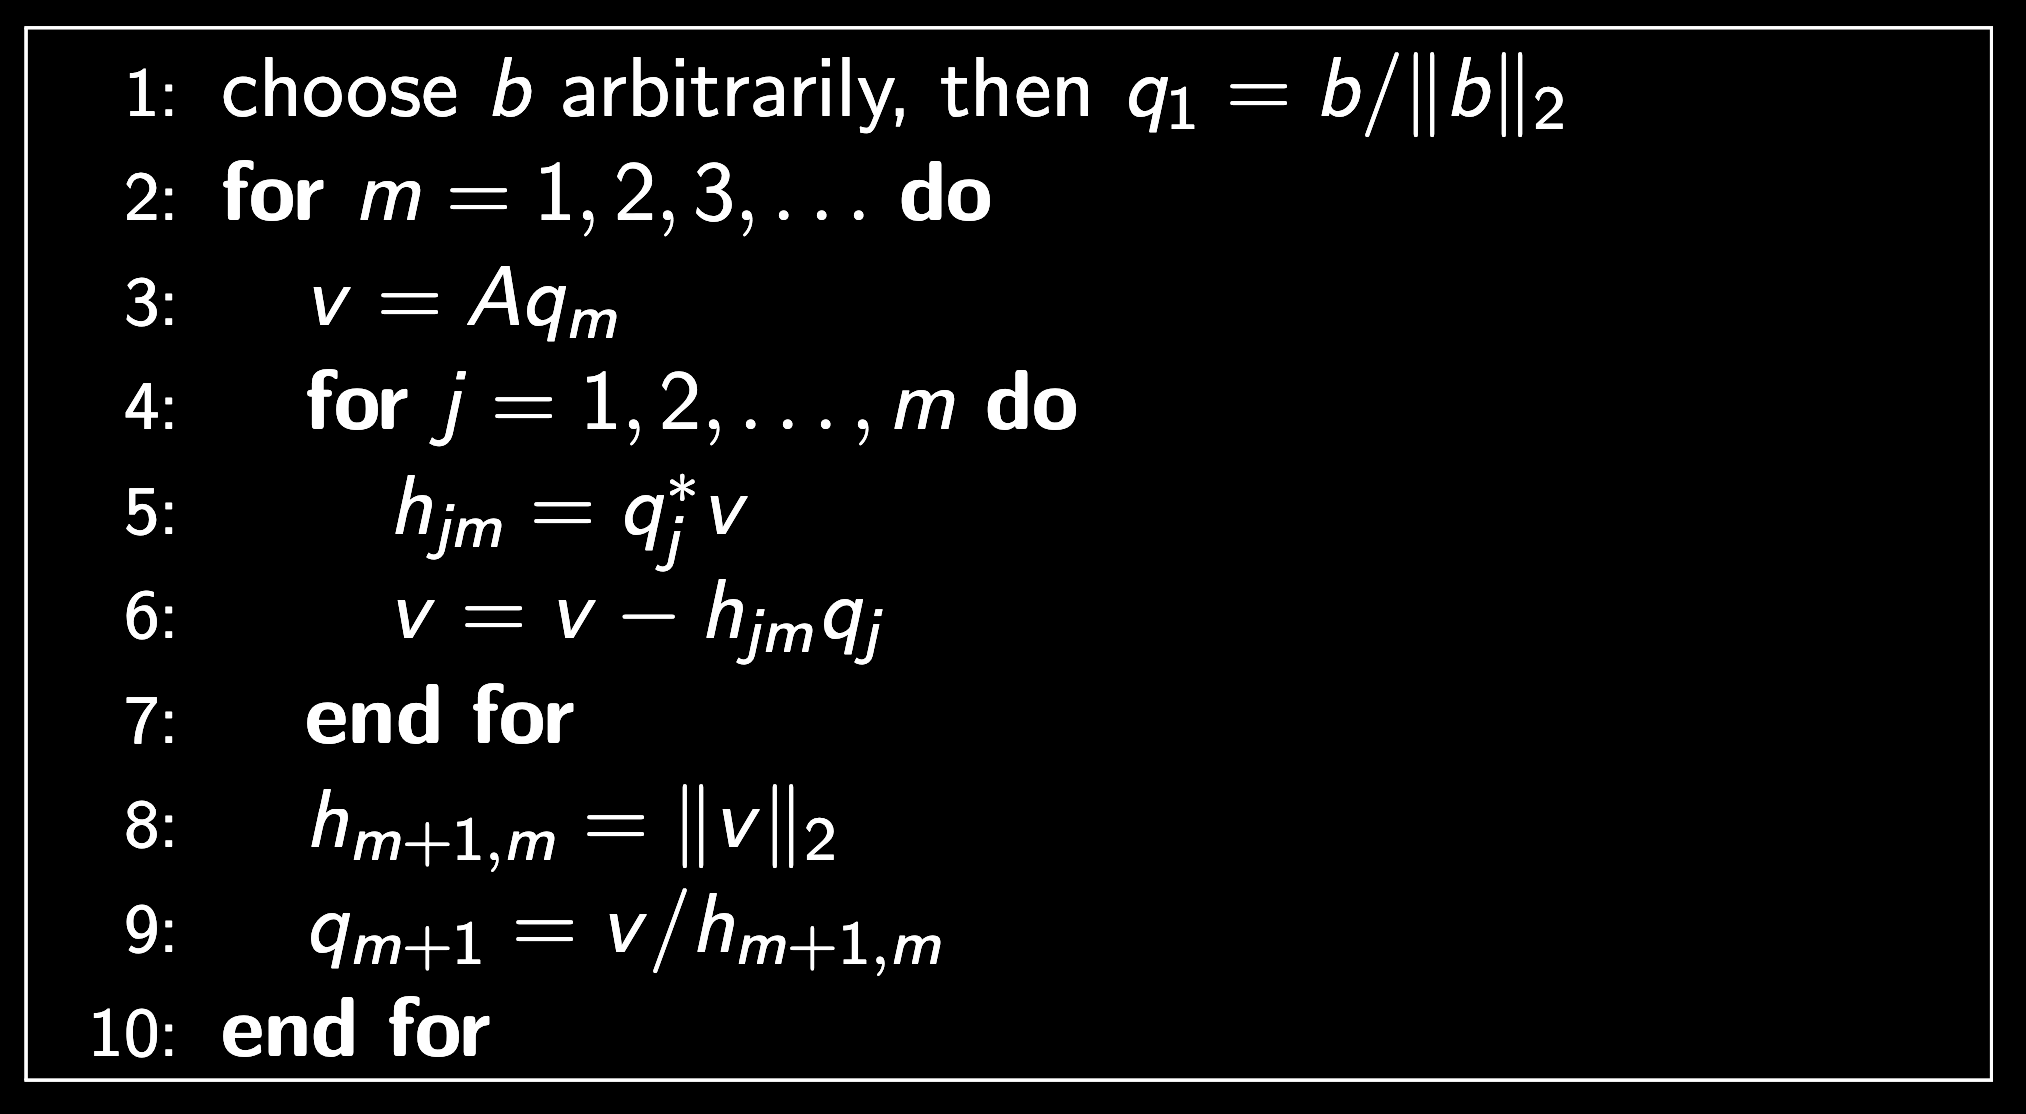

In [206]:
Image(filename='../resources/arnoldi_algo.png', width=750)
# Source: Chris Rycroft's lecture notes

## What is going on here?

+ This is almost the same algorithm as modified Gram-Schmidt, which we saw before
+ The difference is that we are applying the matrix $A$ as an operator to $q$ in each iteration, and thus switching to a new column vector in our Krylov subspace
+ Our output is the reduced matrix $Q_m$
+ Each iteration finds a new basis vector for the corresponding rank-$k$ Krylov subspace

+ After stopping at our $m$ of interest, we can find the reduced Hessenberg matrix $H_m = Q_m^* A Q_m$, where $H_m \in \mathbb{R}^{M \times M}$. Can solve for eigenvalues of this reduced matrix

In [273]:
class ArnoldiIteration:
    """
    Perform the Arnoldi iteration on a matrix A and a vector b.
    """
    def __init__(self, k):
        pass

    def arnoldi_iteration(self, A, b, k):
        n = A.shape[0]
        Q, H = np.zeros((n, k + 1)), np.zeros((k + 1, k))
        Q[:, 0] = b / np.linalg.norm(b)
        for j in range(k):
            v = A @ Q[:, j] # the main difference between the QR and Arnoldi iteration
            for i in range(j + 1):
                H[i, j] = Q[:, i] @ v
                v -= H[i, j] * Q[:, i]
            H[j + 1, j] = np.linalg.norm(v)
            Q[:, j + 1] = v / H[j + 1, j]
        return Q, H

    def eig_k(self, A, k):
        """
        Compute the k largest eigenvalues of A.
        """
        Q, H = self.arnoldi_iteration(A, np.random.rand(A.shape[0]), k)
        return np.linalg.eigvals(H[:-1])

In [271]:
a_big = np.random.random((3000, 3000))
a_big = a_big + a_big.T
eig_topk_np = np.sort(np.linalg.eigvals(a_big))[::-1][:10]

model = ArnoldiIteration(10)
eig_topk_arnoldi = model.eig_k(a_big, 10)

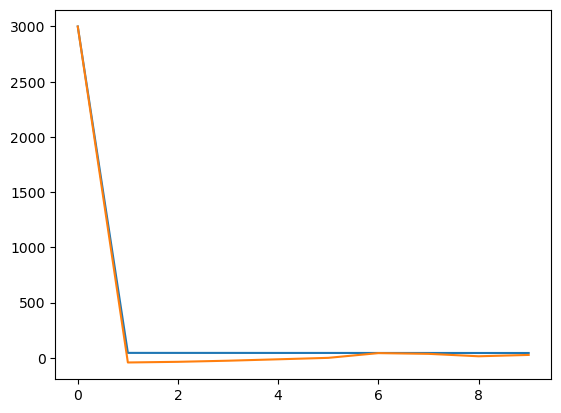

In [275]:
plt.plot(eig_topk_np)
plt.plot(eig_topk_arnoldi)

## Conjugate gradient methods

+ Solve for $\mathbf{x}$ such that $A \mathbf{x} = \mathbf{b}$


+ $(Ax  - b)= \mathbf{r}$

+ An iterative method. We saw that iterative methods are useful for eigenvalue problems, and so it's useful to have a similar approach for linear solving.
+ The basic version only holds for symmetric, positive-definite matrices (like the Hessians of potential functions)


+ Dynamical systems view: the solution is the fixed point of the dynamics of an iterative algorithm, and we want to approach it as fast as possible.
+ The CG iterate $\mathbf{x}_k$ is the unique member of $\mathcal{K}_{k}(A,b)$ which minimizes the distance to the "true" solution.
+ Why not use Gauss-Jordan, or LU factorization, which give us exact answers after finite steps?
+ + If an iterative algorithm converges faster, then we can save time

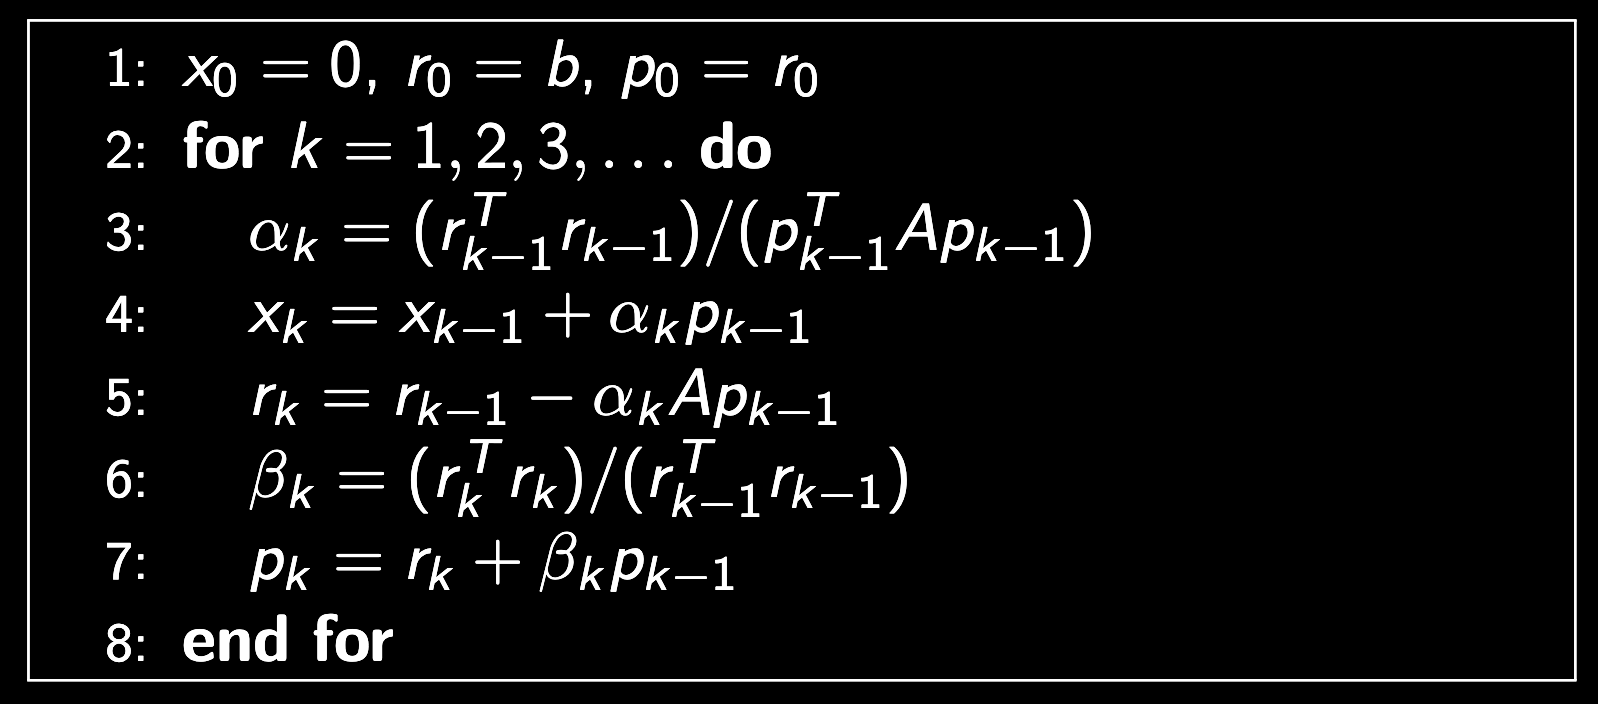

In [83]:
Image("../resources/cg_method.png", width=750)
# Source: Chris Rycroft's lecture notes

#### What's going on here?

+ $\mathbf{r}$ is the vector residual between $A$ times our current guess $\mathbf{x}$ and the target $b$ at the $k^{th}$ step
+ $\mathbf{p}$ is orthogonal to $\mathbf{r}$ (last step looks like a Gram-Schmidt update). It tells us which direction to step in $\mathbf{x}$

<br></br>
+ $\alpha$ is a learning rate for $\mathbf{r}$ that encourages larger steps when the residual is large, but smaller steps when the direction of the orthogonal vector $\mathbf{p}$ is changing quickly 
+ $\beta$ is a learning rate for $\mathbf{p}$ that encourages larger steps when the residual is large, but smaller steps when the residual is changing quickly (avoids oscillations)

<br></br>
+ At each step, we update $p_k$ to be orthogonal to $r_k$. $p_k$ is orthogonal not only to $r_k$, but also all previous $r_j$, $j < k$.


Text(0, 0.5, 'Residual norm')

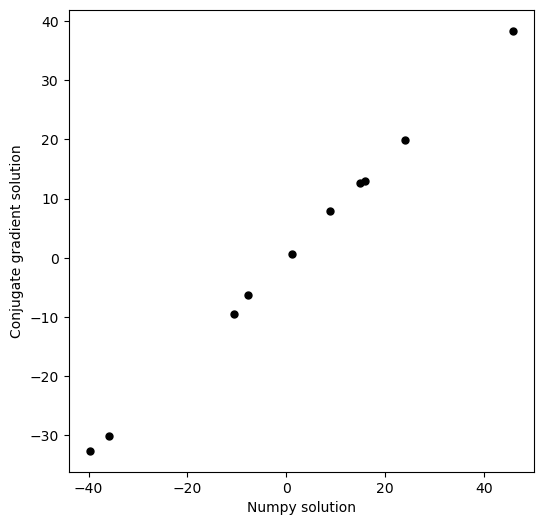

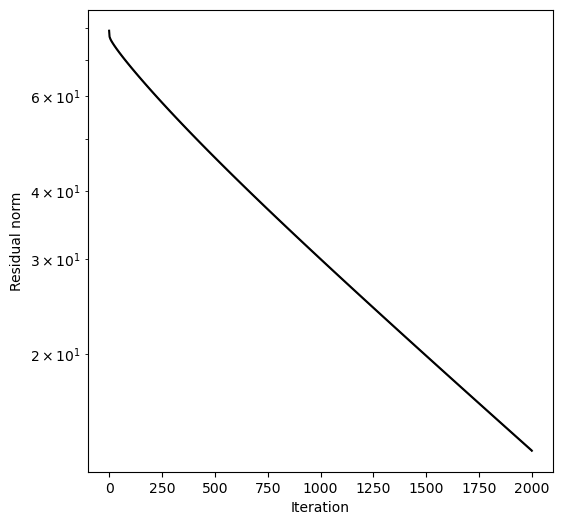

In [3]:
class ConjugateGradientMethod:
    """
    Solve a linear system Ax = b using the conjugate gradient method. A must be a 
    symmetric, positive definite matrix.

    Parameters
        max_iter (int): Maximum number of iterations to perform.
        store_history (bool): If True, store the history of the solution at each 
            iteration.
    """

    def __init__(self, max_iter=1000, store_history=False):
        self.max_iter = max_iter
        self.store_history = store_history

    def solve(self, A, b):

        if self.store_history:
            self.history = list()

        x = np.zeros_like(b)
        r = b
        p = r

        for i in range(self.max_iter):
            alpha = (r.T @ r) / (p.T @ A @ p)
            x = x + alpha * p
            r = r - alpha * A @ p

            # if np.linalg.norm(r) < 1e-12:
            #     break

            beta = (r.T @ r) / (b.T @ b)
            p = r + beta * p

            if self.store_history:
                self.history.append(x.copy())

        return x

    def preconditioner(self, A):
        """
        Return a Jacobi preconditioner for the matrix A.
        """
        return np.diag(1 / np.diag(A))

    def solve_with_preconditioner(self, A, b):
            
        if self.store_history:
            self.history = list()

        x = np.zeros_like(b)
        r = b
        M = self.preconditioner(A)
        z = M @ r # M is the preconditioner
        p = r

        for i in range(self.max_iter):
            alpha = (r.T @ z) / (p.T @ A @ p)
            x = x + alpha * p
            r = r - alpha * A @ p
            z = M @ r 
            beta = (r.T @ z) / (b.T @ b)
            p = z + beta * p

            if self.store_history:
                self.history.append(x.copy())

        return x


np.random.seed(0)
a = np.random.rand(10, 10)
a = a.T @ a # A*A^T is always positive definite 
b = np.random.rand(10, 1)

model = ConjugateGradientMethod(max_iter=2000, store_history=True)
sol_cg = model.solve(a, b).squeeze()
sol_np = np.linalg.solve(a, b).squeeze()

plt.figure(figsize=(6, 6))
plt.plot(sol_np, sol_cg, '.k', markersize=10)
plt.xlabel("Numpy solution")
plt.ylabel("Conjugate gradient solution")


plt.figure(figsize=(6, 6))
all_norms = np.linalg.norm(np.array(model.history).squeeze() - sol_np, axis=1)
plt.semilogy(all_norms, 'k', markersize=10)
plt.xlabel("Iteration")
plt.ylabel("Residual norm")



In [4]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

def plotter(i):
    plt.figure(figsize=(6, 6))
    plt.plot(sol_np, model.history[i], '.k', markersize=20);
    plt.xlabel("Numpy solution")
    plt.ylabel("Conjugate gradient solution")
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(model.history) - 1, 1, layout=Layout(width='800px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='800px'), max=1999), Output()), …

<function __main__.plotter(i)>

## Appendix and other functions

In [ ]:


class Householder:
    
    def __init__(self, A):
        self.A = A
        self.Q = np.zeros_like(A)
        self.R = np.zeros_like(A)
        self._decompose()

    def _decompose(self):
        for i in range(self.A.shape[1]):
            self.Q[:, i] = self.A[:, i]
            for j in range(i):
                self.R[j, i] = np.dot(self.Q[:, j], self.A[:, i])
                self.Q[:, i] -= self.R[j, i] * self.Q[:, j]
            self.R[i, i] = np.linalg.norm(self.Q[:, i])
            self.Q[:, i] /= self.R[i, i]

    def solve(self, b):
        y = np.dot(self.Q.T, b)
        return np.linalg.solve(self.R, y)

    def inverse(self):
        return np.linalg.solve(self.R.T, np.linalg.solve(self.R, np.eye(self.A.shape[0])))

    def __str__(self):
        return "Q:\n{}\nR:\n{}".format(self.Q, self.R)

    def __repr__(self):
        return self.__str__()

class Givens:
    
    def __init__(self, A):
        self.A = A
        self.Q = np.zeros_like(A)
        self.R = np.zeros_like(A)
        self._decompose()

    def _decompose(self):
        for i in range(self.A.shape[1]):
            self.Q[:, i] = self.A[:, i]
            for j in range(i):
                self.R[j, i] = np.dot(self.Q[:, j], self.A[:, i])
                self.Q[:, i] -= self.R[j, i] * self.Q[:, j]
            self.R[i, i] = np.linalg.norm(self.Q[:, i])
            self.Q[:, i] /= self.R[i, i]

    def solve(self, b):
        y = np.dot(self.Q.T, b)
        return np.linalg.solve(self.R, y)

    def inverse(self):
        return np.linalg.solve(self.R.T, np.linalg.solve(self.R, np.eye(self.A.shape[0])))

    def __str__(self):
        return "Q:\n{}\nR:\n{}".format(self.Q, self.R)

    def __repr__(self):
        return self.__str__()

class QR:

    def __init__(self, A):
        self.A = A
        self.Q = np.zeros_like(A)
        self.R = np.zeros_like(A)
        self._decompose()

    def _decompose(self):
        for i in range(self.A.shape[1]):
            self.Q[:, i] = self.A[:, i]
            for j in range(i):
                self.R[j, i] = np.dot(self.Q[:, j], self.A[:, i])
                self.Q[:, i] -= self.R[j, i] * self.Q[:, j]
            self.R[i, i] = np.linalg.norm(self.Q[:, i])
            self.Q[:, i] /= self.R[i, i]

    def solve(self, b):
        y = np.dot(self.Q.T, b)
        return np.linalg.solve(self.R, y)

    def inverse(self):
        return np.linalg.solve(self.R.T, np.linalg.solve(self.R, np.eye(self.A.shape[0])))


class Cholesky:
        
    def __init__(self, A):
        self.A = A
        self.L = np.zeros_like(A)
        self._decompose()

    def _decompose(self):
        for i in range(self.A.shape[0]):
            for j in range(i):
                self.L[i, j] = (self.A[i, j] - np.dot(self.L[i, :j], self.L[j, :j])) / self.L[j, j]
            self.L[i, i] = np.sqrt(self.A[i, i] - np.dot(self.L[i, :i], self.L[i, :i]))

    def solve(self, b):
        y = np.linalg.solve(self.L, b)
        return np.linalg.solve(self.L.T, y)

    def inverse(self):
        return np.linalg.solve(self.L.T, np.linalg.solve(self.L, np.eye(self.A.shape[0])))

    def __str__(self):
        return "L:\n{}\nL.T:\n{}".format(self.L, self.L.T)

    def __repr__(self):
        return self.__str__()


def test():
    A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 10]])
    b = np.array([3, 3, 4])
    print("A:\n{}\nb:\n{}".format(A, b))
    print("QR decomposition")

    qr = QR(A)
    print(qr)
    print("QR solution")
    print(qr.solve(b))
    print("QR inverse")
    print(qr.inverse())
    print("Cholesky decomposition")
    cholesky = Cholesky(A)
    print(cholesky)
    print("Cholesky solution")
    print(cholesky.solve(b))
    print("Cholesky inverse")
    print(cholesky.inverse())

